## 导入相关的模块

In [4]:
# !pip install d2l -i https://pypi.tuna.tsinghua.edu.cn/simple
import os
import torch
import torchvision
from torch import nn
# from d2l import torch as d2l
# help(os)
from torch.utils.data import Dataset
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

## 对数据进行下载导入读取和整理等操作

### 整理数据集

In [19]:
# 

data_dir = './data/kaggle_dog_tiny/kaggle_dog_tiny/'
data_dir1 = os.path.join(data_dir, 'labels.csv')

# 使用numpy读取label.csv中的标签
# 默认情况下，数据被认为是float类型, 所以使用str参数
with open(data_dir1, encoding='utf-8') as f:
    data = np.loadtxt(f, str, delimiter=',')
batch_size=64
valid_ratio=0.1


### 对图像数据进行增广

In [12]:
# 训练集的图像transform
transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08到1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224x224的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [13]:
# 测试集的图像transform
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # 从图像中心裁切224x224大小的图片
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

### 自定义数据集

In [14]:
# 自定义dataset
class myData(Dataset):
    def __init__(self, root_dir, label_dir):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.path = os.path.join(self.root_dir, self.label_dir)
        self.img_path = os.listdir(self.path)  # 存放train图像的路径

    def __getitem__(self, idx):
        img_name = self.img_path[idx]
        img_item_path = os.path.join(self.root_dir, self.label_dir, img_name)
        img = Image.open(img_item_path)
        return img, img_name
    
    def __len__():
        return len(self.img_path)

In [16]:
filename = data_dir
labelname='train'
data = myData(root_dir = filename, label_dir = labelname)
img, label = data[0]
img.show()
print(label)

0097c6242c6f3071762d9f85c3ef1b2f.jpg


### 读取数据集

In [17]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform = transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [21]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)
print(len(train_iter),len(train_valid_iter),len(valid_iter),len(test_iter))

13 15 1 1


## 建立模型

In [22]:
def myNet():
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet18(pretrained=True)
    finetune_net.features
    finetune_net.output=nn.Sequential(nn.Linear(1000,256),
                                     nn.ReLU(),
                                     nn.Linear(256,120))
    finetune_net = finetune_net.to(device=device)
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net


## 采取损失函数和优化器

In [38]:

loss = nn.CrossEntropyLoss(reduction='none')
                                                                       
def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')

## 定义训练测试验证函数

In [69]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

In [39]:
#训练函数
def train_one(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    loss_item=[]
    valid_loss_sum=[]
    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids = devices)
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay = wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches = len(train_iter)
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    for epoch in range(num_epochs):
        loss_sum=0.0
        for i, (features, labels) in enumerate(train_iter):
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            loss_sum += l.item()
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            valid_loss_sum.append(valid_loss.item())
        scheduler.step()
        loss_item.append(loss_sum/(num_batches*64))
    data=np.arange(1,num_epochs+1)
    plt.plot(data,np.array(loss_item))
    plt.plot(data,np.array(valid_loss_sum))
    plt.xlabel('num_epochs')
    plt.ylabel('loss')

d:\IDE_sources\Ancona\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\IDE_sources\Ancona\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


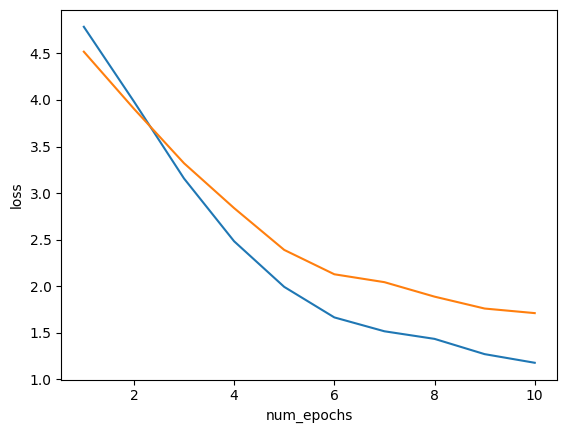

In [40]:
devices, num_epochs, lr, wd = [0], 10, 1e-4, 1e-4
lr_period, lr_decay = 2, 0.9
valid_iter = valid_iter
net=myNet()
train_one(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)